In [1]:
# Import required libraries
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report,roc_curve, auc

In [2]:
df = pd.read_csv("synthetic_river_health_data.csv")
print("Dataset Shape:", df.shape)
print(df.head())

Dataset Shape: (10000, 7)
          Timestamp                            Factory_ID    Industry_Type  \
0  01-01-2023 00:00  3397d76f-2bc2-4668-b59b-9cbdb15526d5  food_processing   
1  01-01-2023 01:00  3397d76f-2bc2-4668-b59b-9cbdb15526d5  food_processing   
2  01-01-2023 02:00  ac4e8d5d-f32c-4622-96c8-e0c6728616e4         chemical   
3  01-01-2023 03:00  170401fd-2cd4-45aa-ae67-66d473fe4174  food_processing   
4  01-01-2023 04:00  ee94bf98-19af-4692-978b-ea7e3c67d788  food_processing   

     pH  Nitrate_Concentration  Temperature  Pollution_Flag  
0  6.72                   6.15        13.25               0  
1  6.79                  12.61        10.83               1  
2  3.07                  76.76        17.65               1  
3  6.69                  16.37        12.09               1  
4  6.63                    NaN        12.12               0  


In [3]:
# Display basic information about the dataset
print("Dataset Info:")
df.info()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Timestamp              10000 non-null  object 
 1   Factory_ID             10000 non-null  object 
 2   Industry_Type          10000 non-null  object 
 3   pH                     9320 non-null   float64
 4   Nitrate_Concentration  9260 non-null   float64
 5   Temperature            9316 non-null   float64
 6   Pollution_Flag         10000 non-null  int64  
dtypes: float64(3), int64(1), object(3)
memory usage: 547.0+ KB


In [4]:
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
Timestamp                  0
Factory_ID                 0
Industry_Type              0
pH                       680
Nitrate_Concentration    740
Temperature              684
Pollution_Flag             0
dtype: int64


In [5]:
# Convert timestamp to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%d-%m-%Y %H:%M')

In [6]:
# Add derived time-based features
df['year'] = df['Timestamp'].dt.year
df['month'] = df['Timestamp'].dt.month
df['day'] = df['Timestamp'].dt.day
df['hour'] = df['Timestamp'].dt.hour
df['is_weekend'] = df['Timestamp'].dt.weekday.isin([5, 6]).astype(int)

In [7]:
# Handle missing values
# Fill missing pH values with median by industry
df['pH'] = df.groupby('Industry_Type')['pH'].transform(
    lambda x: x.fillna(x.median())
)

# Fill missing temperature values with median by industry
df['Temperature'] = df.groupby('Industry_Type')['Temperature'].transform(
    lambda x: x.fillna(x.median())
)

In [8]:
# Fill missing nitrate values with median by industry
df['Nitrate_Concentration'] = df.groupby('Industry_Type')['Nitrate_Concentration'].transform(
    lambda x: x.fillna(x.median())
)

In [9]:
# Create binary flags for concerning levels
df['high_nitrate'] = (df['Nitrate_Concentration'] > 50).astype(int)
df['acidic_ph'] = (df['pH'] < 6.0).astype(int)
df['high_temp'] = (df['Temperature'] > 25.0).astype(int)

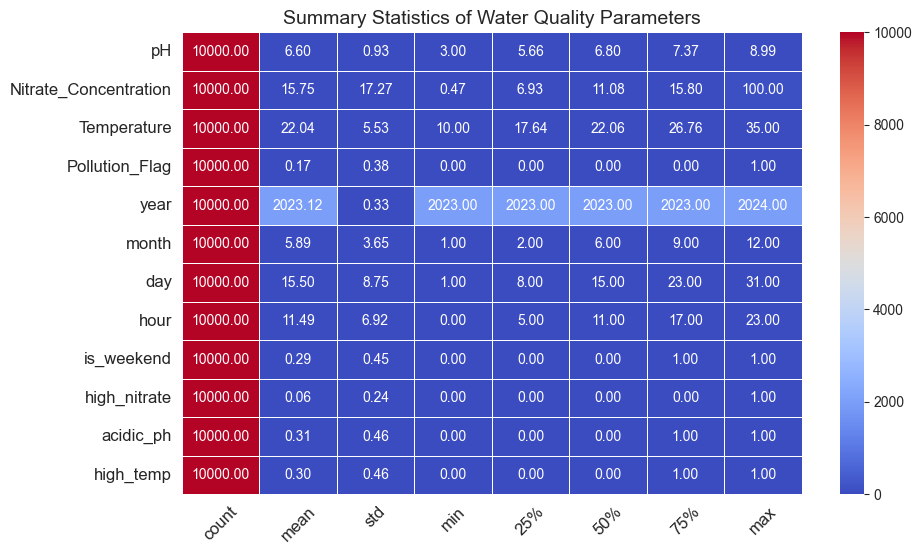

In [10]:
# Display summary statistics
# Remove non-numeric columns before computing statistics
df_numeric = df.select_dtypes(include=['number']).drop(columns=['Factory_ID'], errors='ignore')

# Compute summary statistics
summary_stats = df_numeric.describe().T

# Set seaborn style
sns.set_style("whitegrid")

# Plot Summary Statistics
plt.figure(figsize=(10, 6))
sns.heatmap(summary_stats, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5, cbar=True)

# Titles and labels
plt.title("Summary Statistics of Water Quality Parameters", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

plt.show()

In [11]:
# Check distribution of measurements by industry
print("\nMeasurements by Industry:")
print(df['Industry_Type'].value_counts())


Measurements by Industry:
Industry_Type
food_processing    3375
chemical           3334
textile            3291
Name: count, dtype: int64


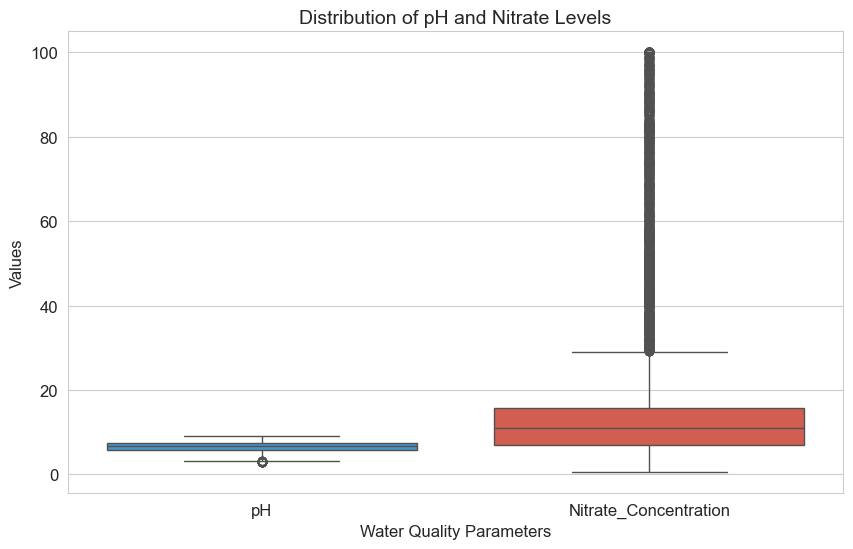

In [12]:
# Set Seaborn style
sns.set_style("whitegrid")

# Create a figure for the box plots
plt.figure(figsize=(10, 6))

# Plot boxplots for pH and Nitrate
sns.boxplot(data=df[['pH', 'Nitrate_Concentration']], palette=["#3498db", "#e74c3c"])

# Customize titles and labels
plt.title("Distribution of pH and Nitrate Levels", fontsize=14)
plt.xlabel("Water Quality Parameters", fontsize=12)
plt.ylabel("Values", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.show()


Dataset Correlation Matrix:
                             pH  Nitrate_Concentration  Temperature  \
pH                     1.000000              -0.306683     0.289606   
Nitrate_Concentration -0.306683               1.000000     0.103665   
Temperature            0.289606               0.103665     1.000000   
Pollution_Flag        -0.033924               0.674027     0.000517   
year                   0.003584              -0.015350    -0.287660   
month                 -0.003600               0.007084     0.226494   
day                   -0.013571               0.009740     0.031767   
hour                   0.007793              -0.001503     0.002583   
is_weekend             0.004637               0.017097     0.006313   
high_nitrate          -0.251978               0.885666    -0.004961   
acidic_ph             -0.872474               0.283260    -0.069158   
high_temp              0.305107               0.048917     0.799255   

                       Pollution_Flag      year

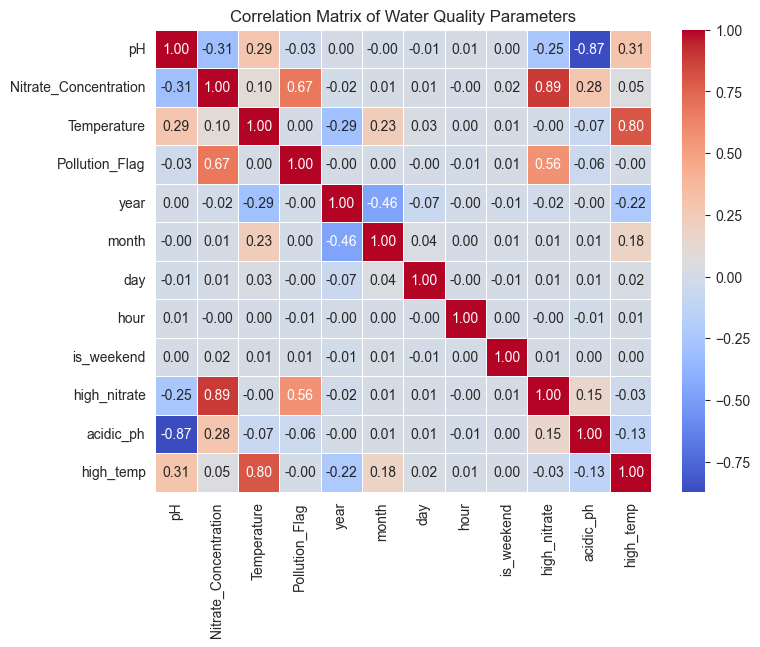

In [13]:
# Remove non-numeric columns before computing the correlation matrix
df_numeric = df.select_dtypes(include=['number']).drop(columns=['Factory_ID'], errors='ignore')

# Compute correlation matrix
correlation_matrix = df_numeric.corr()

# Print correlation matrix
print("\nDataset Correlation Matrix:")
print(correlation_matrix)

# Visualize correlation matrix as a heatmap
plt.figure(figsize=(8,6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Water Quality Parameters")
plt.show()


In [14]:
# Calculate violation rates by industry
violation_rates = df.groupby('Industry_Type')['Pollution_Flag'].mean()
print("\nViolation Rates by Industry:")
print(violation_rates)


Violation Rates by Industry:
Industry_Type
chemical           0.208458
food_processing    0.147259
textile            0.160134
Name: Pollution_Flag, dtype: float64


In [15]:
# Save preprocessed dataset
df.to_csv('river_health_preprocessed.csv', index=False)

In [16]:
df_clean = pd.read_csv('river_health_preprocessed.csv')

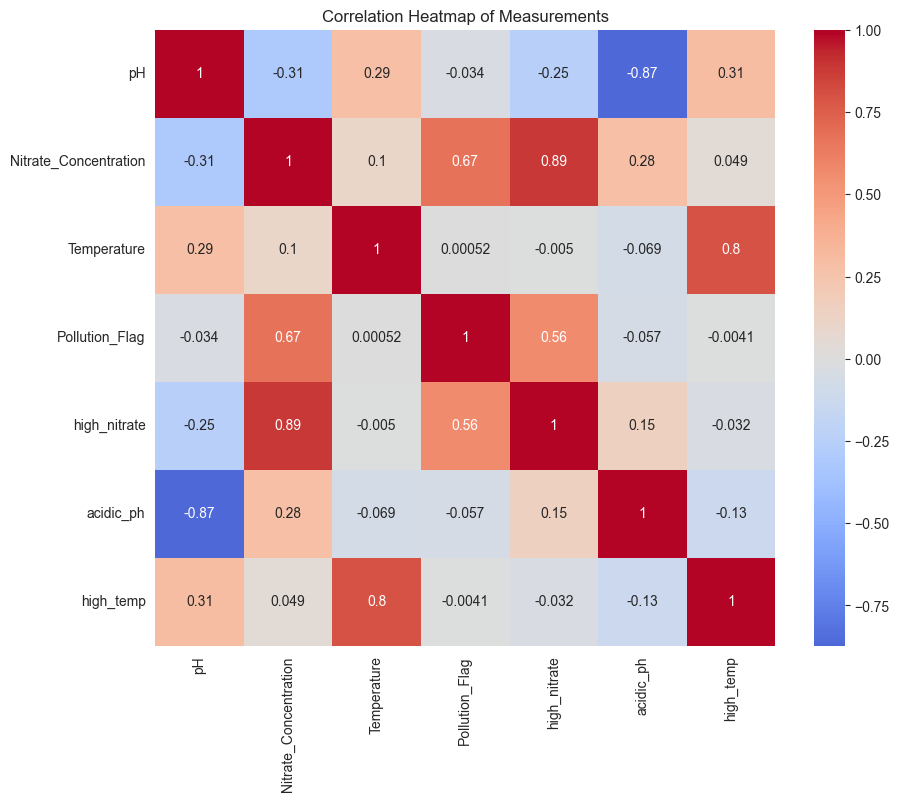

In [17]:
def plot_correlation_heatmap():
    numeric_cols = ['pH', 'Nitrate_Concentration', 'Temperature', 'Pollution_Flag',
                    'high_nitrate', 'acidic_ph', 'high_temp']
    correlation = df_clean[numeric_cols].corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation, annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation Heatmap of Measurements')
    plt.show()
plot_correlation_heatmap()

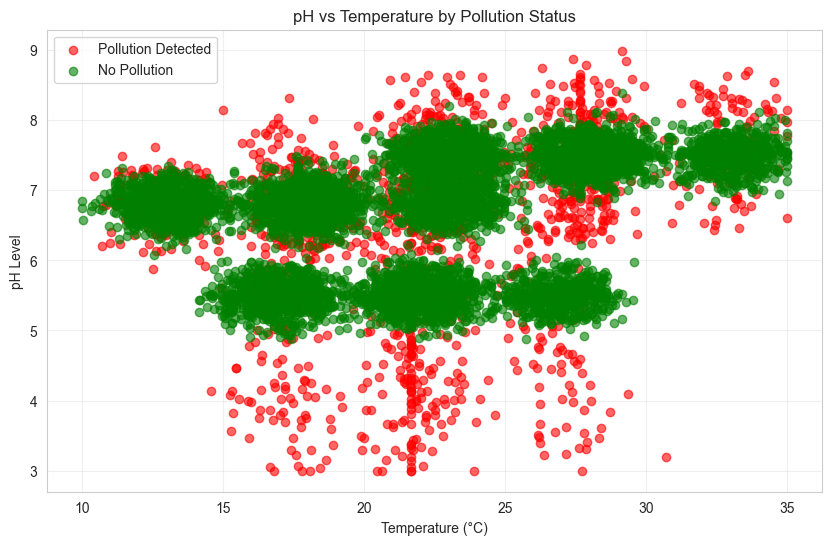

In [18]:
plt.figure(figsize=(10,6))

# Plot for measurements that indicate pollution
plt.scatter(df_clean.Temperature[df_clean.Pollution_Flag == 1],
           df_clean.pH[df_clean.Pollution_Flag == 1],
           color='red',
           alpha=0.6,
           label='Pollution Detected')

# Plot for measurements that don't indicate pollution
plt.scatter(df_clean.Temperature[df_clean.Pollution_Flag == 0],
           df_clean.pH[df_clean.Pollution_Flag == 0],
           color='green',
           alpha=0.6,
           label='No Pollution')

plt.title("pH vs Temperature by Pollution Status")
plt.xlabel("Temperature (°C)")
plt.ylabel("pH Level")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

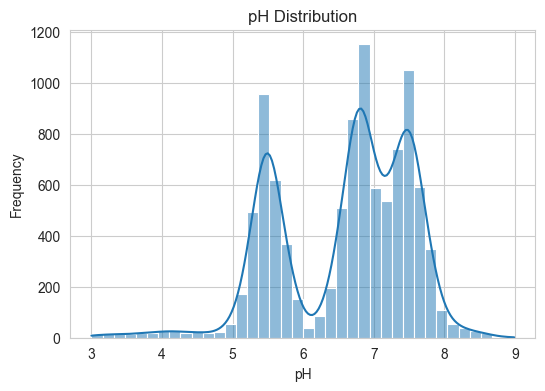

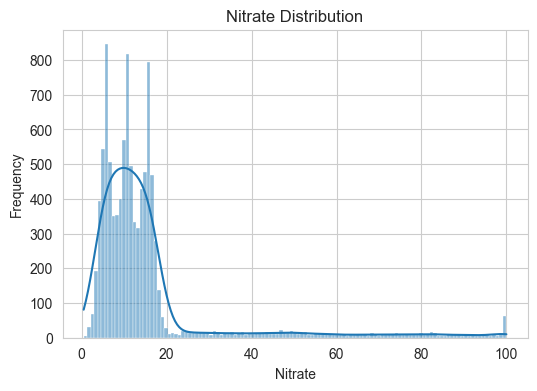

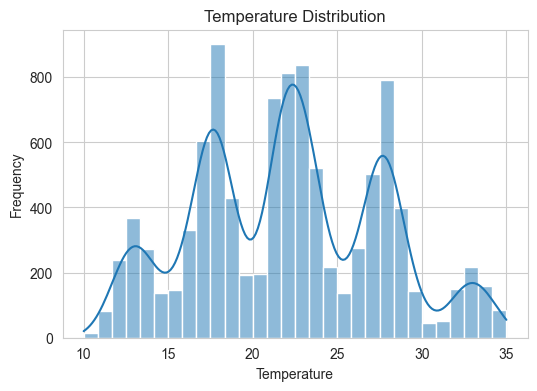

In [19]:
# Histogram for pH
plt.figure(figsize=(6, 4))
sns.histplot(df_clean['pH'].dropna(), kde=True)
plt.title('pH Distribution')
plt.xlabel('pH')
plt.ylabel('Frequency')
plt.show()

# Histogram for Nitrate
plt.figure(figsize=(6, 4))
sns.histplot(df_clean['Nitrate_Concentration'].dropna(), kde=True)
plt.title('Nitrate Distribution')
plt.xlabel('Nitrate')
plt.ylabel('Frequency')
plt.show()

# Histogram for Temperature
plt.figure(figsize=(6, 4))
sns.histplot(df_clean['Temperature'].dropna(), kde=True)
plt.title('Temperature Distribution')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.show()

In [20]:
# Encode categorical variable 'factory_industry'
encoder = LabelEncoder()
df_clean["Industry_Type"] = encoder.fit_transform(df_clean["Industry_Type"])

In [21]:
# Select features and target
X = df_clean[["Industry_Type", "pH", "Nitrate_Concentration", "Temperature"]]
y = df_clean["Pollution_Flag"]

In [22]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [23]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [24]:
# Initialize models
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC()
}

C:\Users\badve\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8377 - loss: 0.3800 - precision: 0.6359 - recall: 0.4621 - val_accuracy: 0.9490 - val_loss: 0.1574 - val_precision: 1.0000 - val_recall: 0.6955
Epoch 2/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9567 - loss: 0.1504 - precision: 0.9931 - recall: 0.7560 - val_accuracy: 0.9615 - val_loss: 0.1313 - val_precision: 1.0000 - val_recall: 0.7701
Epoch 3/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9640 - loss: 0.1337 - precision: 0.9829 - recall: 0.8009 - val_accuracy: 0.9645 - val_loss: 0.1224 - val_precision: 0.9962 - val_recall: 0.7910
Epoch 4/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9679 - loss: 0.1214 - precision: 0.9832 - recall: 0.8231 - val_accuracy: 0.9690 - val_loss: 0.1105 - val_precision: 0.9964 - val_recall: 0.8179
Epoch 5/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9692 - loss: 0.1202 - precision: 0.9840 - recall: 0.8382 - val_accuracy: 0.9725 - val_loss: 0.

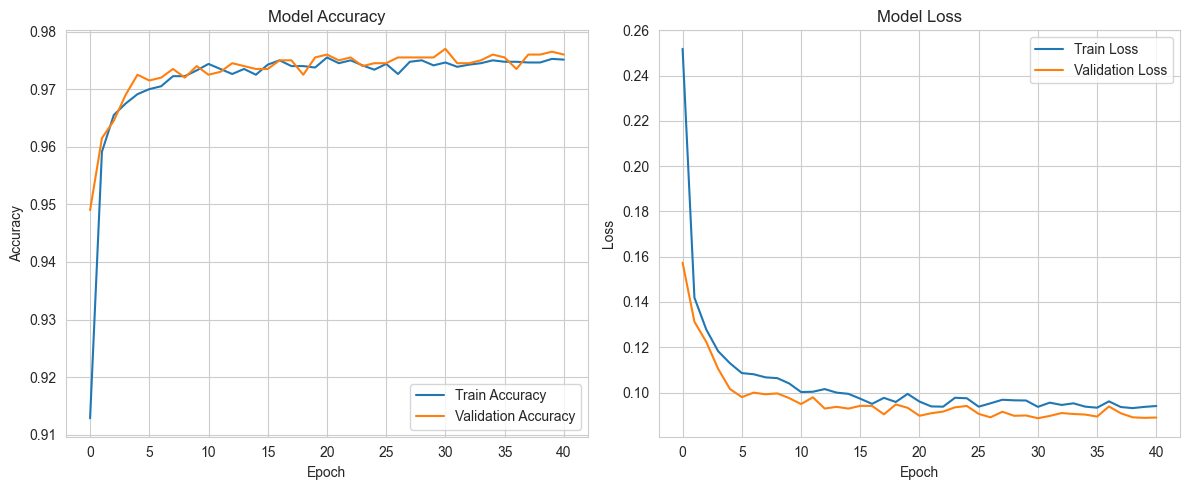

In [25]:
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

input_shape = X_train.shape[1]

def create_mlp_model(input_dim):
    model = keras.Sequential([

        keras.layers.Dense(64, activation='relu', input_shape=(input_dim,)),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    return model

# Create the MLP model instance
mlp_model = create_mlp_model(input_shape)

# --- 2. Train the Model ---

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True
)


history = mlp_model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
    verbose=1
)

# --- 3. Evaluate the Model ---
y_pred_prob_mlp = mlp_model.predict(X_test)
y_pred_mlp = (y_pred_prob_mlp > 0.5).astype("int32")
y_test_flat = y_test.values.flatten()
y_pred_mlp_flat = y_pred_mlp.flatten()
conf_matrix_mlp = confusion_matrix(y_test_flat, y_pred_mlp_flat)
class_report_mlp = classification_report(y_test_flat, y_pred_mlp_flat, target_names=['Not Polluted (0)', 'Polluted (1)'])
print("\nConfusion Matrix (MLP):\n", conf_matrix_mlp)
print("\nClassification Report (MLP):\n", class_report_mlp)
plt.figure(figsize=(12, 5))
# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8622 - loss: 0.4890 - val_accuracy: 0.9435 - val_loss: 0.1827
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9520 - loss: 0.1612 - val_accuracy: 0.9590 - val_loss: 0.1495
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9625 - loss: 0.1408 - val_accuracy: 0.9635 - val_loss: 0.1323
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9701 - loss: 0.1130 - val_accuracy: 0.9690 - val_loss: 0.1211
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9677 - loss: 0.1194 - val_accuracy: 0.9705 - val_loss: 0.1177
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9680 - loss: 0.1197 - val_accuracy: 0.9695 - val_loss: 0.1139
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9686 - loss: 0.1190 - val_accuracy: 0.9680 - val_loss: 0.1178
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9713 - loss: 0.1119 - val_accuracy: 0.

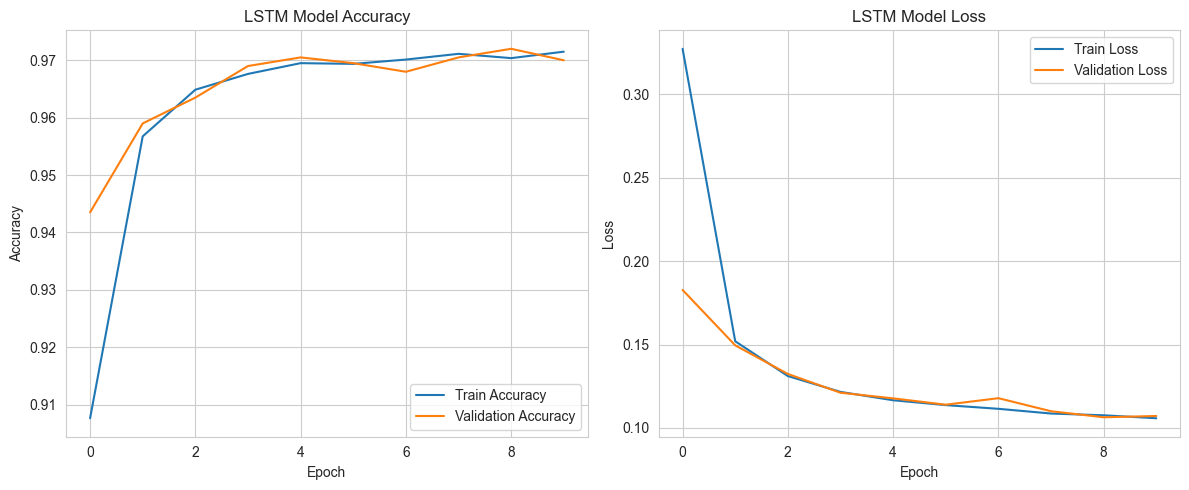

In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

# Reshape data for LSTM (samples, timesteps, features)
X_train_seq = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test_seq = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# LSTM Model
lstm_model = Sequential([
    Input(shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    LSTM(64, return_sequences=True),
    Dropout(0.3),
    LSTM(32),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_lstm = lstm_model.fit(
    X_train_seq, y_train,
    validation_data=(X_test_seq, y_test),
    epochs=10,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# Evaluate the LSTM model
loss_lstm, accuracy_lstm = lstm_model.evaluate(X_test_seq, y_test)
print(f"\nLSTM Model Accuracy: {accuracy_lstm:.2f}")

y_pred_prob_lstm = lstm_model.predict(X_test_seq)
y_pred_lstm = (y_pred_prob_lstm > 0.5).astype("int32")

conf_matrix_lstm = confusion_matrix(y_test, y_pred_lstm)
class_report_lstm = classification_report(y_test, y_pred_lstm)

print("\nConfusion Matrix (LSTM):\n", conf_matrix_lstm)
print("\nClassification Report (LSTM):\n", class_report_lstm)

# Plot training history
plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['accuracy'], label='Train Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['loss'], label='Train Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


Model: Logistic Regression
  Accuracy: 94.80%
  Precision: 95.11%
  Recall: 94.80%
  F1 Score: 94.40%

Model: Decision Tree
  Accuracy: 95.80%
  Precision: 95.81%
  Recall: 95.80%
  F1 Score: 95.80%

Model: Random Forest
  Accuracy: 97.75%
  Precision: 97.75%
  Recall: 97.75%
  F1 Score: 97.71%

Model: SVM
  Accuracy: 96.85%
  Precision: 96.96%
  Recall: 96.85%
  F1 Score: 96.72%

Model: LSTM
  Precision: 97.00%
  Recall: 97.00%
  F1 Score: 97.00%
  Accuracy: 97.20%

Model: MLP
  Precision: 98.00%
  Recall: 98.00%
  F1 Score: 98.00%
  Accuracy: 97.60%


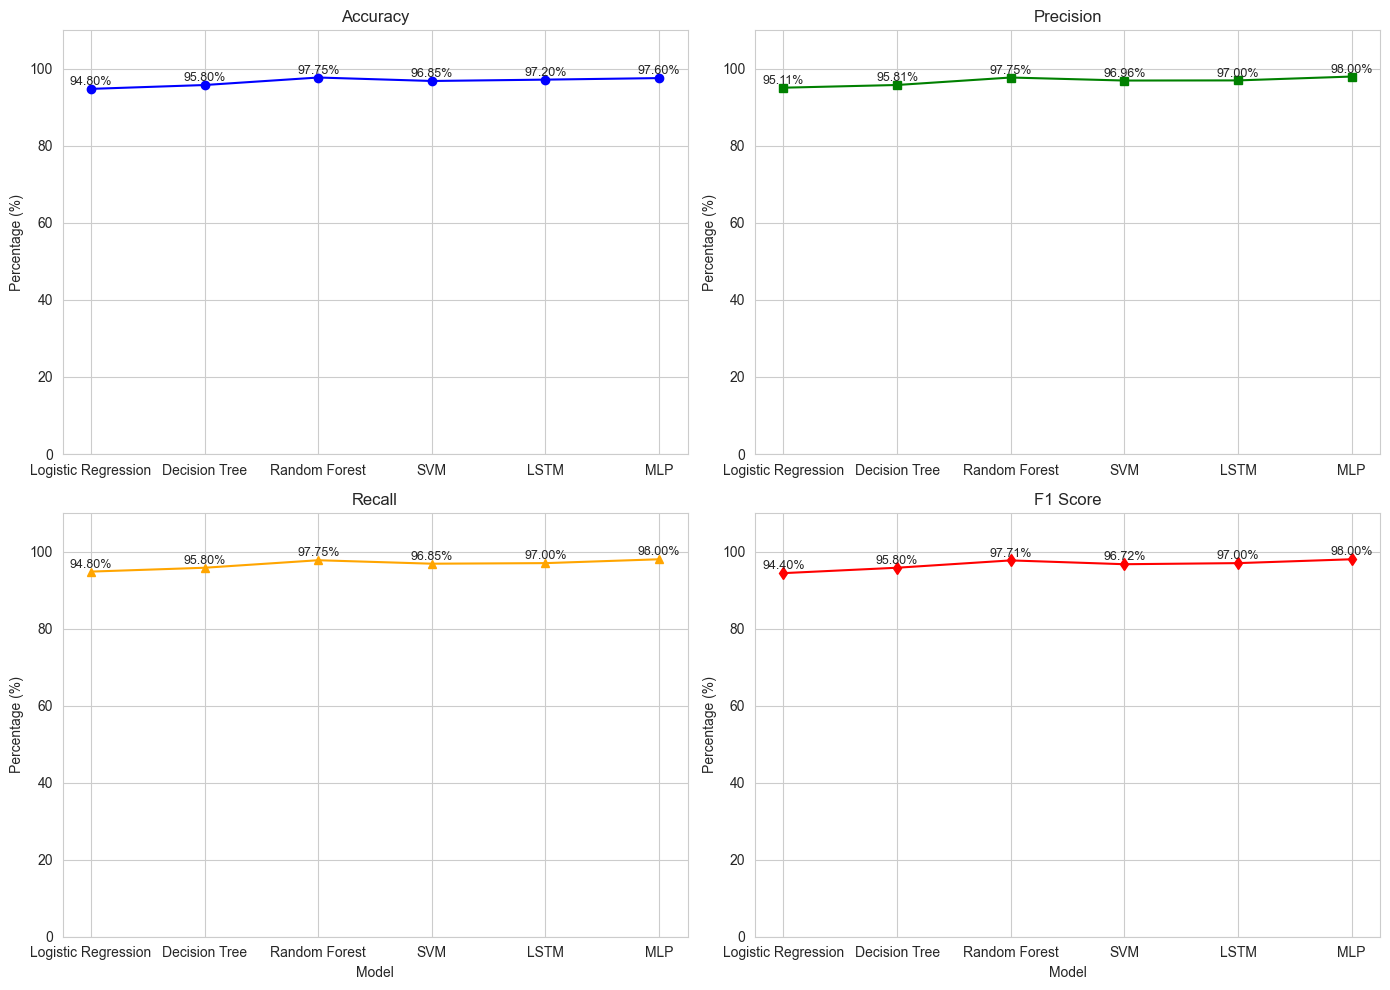

In [39]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Initialize result dictionary
evaluation_results = {}
best_model = None
best_accuracy = 0
best_model_name = ""

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate all metrics
    accuracy = accuracy_score(y_test, y_pred) * 100
    precision = precision_score(y_test, y_pred, average='weighted') * 100
    recall = recall_score(y_test, y_pred, average='weighted') * 100
    f1 = f1_score(y_test, y_pred, average='weighted') * 100

    evaluation_results[name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1
    }

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
        best_model_name = name

# Extract metrics for the LSTM model
class_report_lstm_lines = class_report_lstm.split('\n')
lstm_metrics = {}
for line in class_report_lstm_lines:
    if 'weighted avg' in line:
        parts = line.split()
        lstm_metrics['Precision'] = float(parts[2]) * 100
        lstm_metrics['Recall'] = float(parts[3]) * 100
        lstm_metrics['F1 Score'] = float(parts[4]) * 100

# Get accuracy from the LSTM model evaluation
lstm_metrics['Accuracy'] = accuracy_lstm * 100


# Add LSTM results to evaluation_results dictionary
evaluation_results['LSTM'] = lstm_metrics


# Extract metrics for the MLP model from the classification report
class_report_mlp_lines = class_report_mlp.split('\n')
mlp_metrics = {}
for line in class_report_mlp_lines:
    if 'weighted avg' in line:
        parts = line.split()
        mlp_metrics['Precision'] = float(parts[2]) * 100
        mlp_metrics['Recall'] = float(parts[3]) * 100
        mlp_metrics['F1 Score'] = float(parts[4]) * 100

# Get accuracy from the MLP model evaluation (assuming it's available from the history object or model.evaluate)
# Since we have the history object, we can get the last validation accuracy
mlp_metrics['Accuracy'] = history.history['val_accuracy'][-1] * 100

# Add MLP results to evaluation_results dictionary
evaluation_results['MLP'] = mlp_metrics


# Extract metrics for plotting
model_names = list(evaluation_results.keys())
accuracies = [evaluation_results[model]['Accuracy'] for model in model_names]
precisions = [evaluation_results[model]['Precision'] for model in model_names]
recalls = [evaluation_results[model]['Recall'] for model in model_names]
f1_scores = [evaluation_results[model]['F1 Score'] for model in model_names]


# Print results for all models
for model, metrics in evaluation_results.items():
    print(f"\nModel: {model}")
    for metric, val in metrics.items():
        print(f"  {metric}: {val:.2f}%")


# Set figure size
plt.figure(figsize=(14, 10))

# Accuracy Plot
plt.subplot(2, 2, 1)
plt.plot(model_names, accuracies, marker='o', color='blue')
for i, val in enumerate(accuracies):
    plt.text(i, val + 1, f"{val:.2f}%", ha='center', fontsize=9)
plt.title('Accuracy')
plt.ylabel('Percentage (%)')
plt.ylim(0, 110)
plt.grid(True)

# Precision Plot
plt.subplot(2, 2, 2)
plt.plot(model_names, precisions, marker='s', color='green')
for i, val in enumerate(precisions):
    plt.text(i, val + 1, f"{val:.2f}%", ha='center', fontsize=9)
plt.title('Precision')
plt.ylabel('Percentage (%)')
plt.ylim(0, 110)
plt.grid(True)

# Recall Plot
plt.subplot(2, 2, 3)
plt.plot(model_names, recalls, marker='^', color='orange')
for i, val in enumerate(recalls):
    plt.text(i, val + 1, f"{val:.2f}%", ha='center', fontsize=9)
plt.title('Recall')
plt.xlabel('Model')
plt.ylabel('Percentage (%)')
plt.ylim(0, 110)
plt.grid(True)

# F1 Score Plot
plt.subplot(2, 2, 4)
plt.plot(model_names, f1_scores, marker='d', color='red')
for i, val in enumerate(f1_scores):
    plt.text(i, val + 1, f"{val:.2f}%", ha='center', fontsize=9)
plt.title('F1 Score')
plt.xlabel('Model')
plt.ylabel('Percentage (%)')
plt.ylim(0, 110)
plt.grid(True)

plt.tight_layout()
plt.show()

In [40]:
# Find the best model based on accuracy
best_accuracy = 0
best_model_name = ""

for model, metrics in evaluation_results.items():
    if metrics['Accuracy'] > best_accuracy:
        best_accuracy = metrics['Accuracy']
        best_model_name = model

print(f"The best performing model is: {best_model_name}")
print(f"Metrics for {best_model_name}:")
for metric, val in evaluation_results[best_model_name].items():
    print(f"  {metric}: {val:.2f}%")

The best performing model is: Random Forest
Metrics for Random Forest:
  Accuracy: 97.75%
  Precision: 97.75%
  Recall: 97.75%
  F1 Score: 97.71%


In [42]:
# Evaluate best model
y_pred_best = best_model.predict(X_test)
y_pred_prob = best_model.predict_proba(X_test)[:, 1]  # Probability scores for ROC curve
conf_matrix = confusion_matrix(y_test, y_pred_best)
class_report = classification_report(y_test, y_pred_best)

In [43]:
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)


Confusion Matrix:
 [[1658    7]
 [  38  297]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      1665
           1       0.98      0.89      0.93       335

    accuracy                           0.98      2000
   macro avg       0.98      0.94      0.96      2000
weighted avg       0.98      0.98      0.98      2000



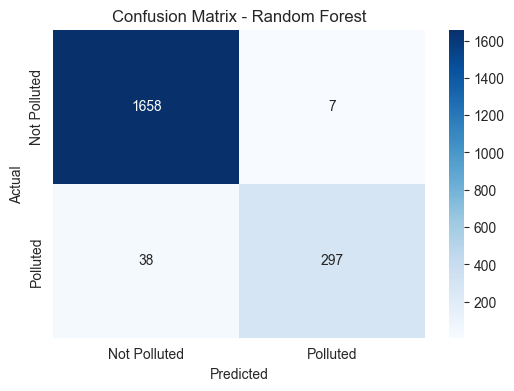

In [44]:
# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Polluted", "Polluted"], yticklabels=["Not Polluted", "Polluted"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix - {best_model_name}")
plt.show()

In [45]:
# Compute ROC curve and AUC score
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

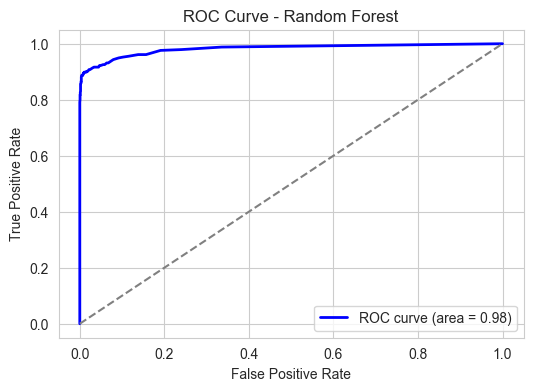

In [46]:
# Plot ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve - {best_model_name}")
plt.legend(loc="lower right")
plt.show()

In [47]:
joblib.dump(best_model, "best_model.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(encoder, "encoder.pkl")

['encoder.pkl']